In [41]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify

XSCHEM_RCFILE = "/opt/pdks/sky130A/libs.tech/xschem/xschemrc"
SPICE_DIR = "./spice/"
OUTPUT_DIR = "./output/"
XSCHEM_DIR = "./xschem/"

In [42]:
class test:
    def __init__(self, composed = 0, parametros ={}, lamb = None, target_param = ""):
        self.composed = composed
        self.parametros = parametros
        self.lamd = lamb
        self.target_param = target_param
    def eval(funct):
        return {"eval": funct}

In [43]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.2                                     # LDO output voltage
Vin = 1.8                                      # LDO supply voltage
Vref = 0.9                                     # LDO voltage reference
IL = 100e-3                                      # Load current
CL = 50e-12                                        # Load capacitance
RL = Vout/IL

## LDO specifications
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

# Initial macros

In [44]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.05,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 0.95}
                              )
stage2_OTA_macro.area_conditions = [10e-3, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_aload"), Symbol("L_aload")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

# Primitives

In [45]:
## PASS TRANSISTOR MACROMODEL

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-1.8, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro/(IL/20e-6)).flatten()}
pt.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

## OTA stage2 transistor MACROMODEL

stage2_t = cs_pmos(netlist='pmos_cm', 
                   type='pmos', 
                   inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vout"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'vgs_lut': (-1.8, -0.1, 0.01), 
                           'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'il': 20e-6,
                           'length': lengths, 
                           '2d_var': ['length', 'vgs']})
stage2_t.build()

stage2_t.parameters = {Symbol('gm_stage2'): np.asarray(stage2_t.gm).flatten(),
                 Symbol('Ro_stage2'): np.asarray(stage2_t.Ro).flatten()}
stage2_t.outputs = {Symbol("W_2stage"): np.asarray(stage2_t.W).flatten(),
                    Symbol("L_2stage"): np.asarray(stage2_t.L).flatten()}

## OTA stage1 differential pair

vs = np.linspace(0.1, 0.8, 20)
vds_diffpar = stage2_OTA_macro.electrical_parameters["Vaouts1"] - vs
vgs_diffpar = stage2_OTA_macro.electrical_parameters["Vpos"] - vs

diffpair_primitive = simplediffpair(netlist='simplediffpair', type='nmos', inputs={'vds_lut': (0.1, 1.2, 0.01), 'vgs_lut': (0.1, 1.8, 0.01), 'vds': vds_diffpar, 'vgs': vgs_diffpar, 'il': 20e-6,
                  'length': lengths, '2d_var': ['vds', 'vgs']})

diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs).flatten()}
diffpair_primitive.outputs = {Symbol("W_diff"): np.asarray(diffpair_primitive.W).flatten(),
                              Symbol("L_diff"): np.asarray(diffpair_primitive.L).flatten()}

## OTA stage1 active load

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      netlist='pmos_cm ', 
                      type='pmos', 
                      inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'il': 20e-6,
                              'length': lengths, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("Raload_2"): 1/np.asarray(ota_cm_pmos.gm).flatten(),
                          Symbol("gaload"): np.asarray(ota_cm_pmos.gm).flatten()}
ota_cm_pmos.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

length
vgs
0
length
vgs
0
vds
vgs
1


KeyboardInterrupt: 

# Specifications

In [6]:
## LDO MACROMODEL

#################### PSRR LDO MACRO #######################
psrr_LDO_macro = test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                   Symbol("V2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rl"): RL,
                   Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                   Symbol("R1"): 100000,
                   Symbol("R2"): 300000}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(-70/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = test()
bw_LDO_macro.name = "bw_LDO"
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                  Symbol("V2"): 0,
                  Symbol("Rl"): RL,
                  Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                  Symbol("R1"): 100000,
                  Symbol("R2"): 300000}
bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"frec": [bw_LDO_macro.tf, -0.70794]}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = test()
loadreg_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
loadreg_LDO_macro.parametros = {Symbol("V1"): 1.8,
                      Symbol("V2"): 0.9,
                      Symbol("s"): 0,
                      Symbol("Cl"): CL,
                      Symbol("Cc"): 1e-12,
                      Symbol("R1"): 100000,
                      Symbol("R2"): 300000}
loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

## 2stage_OTA MACROMODEL

#################### PSRR 2 stage OTA #######################
psrr_2stage_OTA = test()
psrr_2stage_OTA.name = "psrr_2stage"
psrr_2stage_OTA.tf = ["vout", "V_p"]
psrr_2stage_OTA.netlist = "stage2_OTA"
psrr_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0, 
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}

psrr_2stage_OTA.opt_goal = "max"
psrr_2stage_OTA.conditions = {"min": [10**(30/20)]}
psrr_2stage_OTA.variables = {}
psrr_2stage_OTA.out_def = {"eval": psrr_2stage_OTA.tf}
 
#################### BW 2 stage OTA #######################
bw_2stage_OTA = test()
bw_2stage_OTA.name = "bw_2stage"
bw_2stage_OTA.tf = ["vout", "V_p"]
bw_2stage_OTA.netlist = "stage2_OTA"
bw_2stage_OTA.parametros = { Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_2stage_OTA.variables = {}
bw_2stage_OTA.out_def = {"eval": bw_2stage_OTA.tf}

#################### rout 2 stage OTA #######################
rout_2stage_OTA = test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "stage2_OTA_r"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 0,
                   Symbol("V3"): 0,
                   Symbol("V4"): 1,
                   Symbol("Ra_1"): 1000,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [4.641589e+05]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

#################### gm 2 stage OTA #######################

gm_2stage_OTA = test()
gm_2stage_OTA.target_param = Symbol("gma")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "V_p"]
gm_2stage_OTA.netlist = "stage2_OTA"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [psrr_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"

gm_2stage_OTA.conditions = {"min": [0.001]}

## 1stage_OTA MACROMODEL

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_cap"
psrr_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Cl"): 1e-12}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [40]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.netlist = "ota_cap"
bw_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"eval": bw_1stage_OTA.tf}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_cap_r"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 0,
                   Symbol("Vr"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rr"): 1000,
                   Symbol("Cl"): 1e-12}
rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1.291550e+03]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

gm_1stage_OTA = test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_cap"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [psrr_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"

gm_1stage_OTA.conditions = {"min": [0.0001]}



# Sizes

# Exploration

In [28]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.05,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 0.95}
                              )
stage2_OTA_macro.area_conditions = [10e-3, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_aload"), Symbol("L_aload")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

In [29]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [stage2_OTA_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0

stage2_OTA_macro.primitives = [stage2_t]
stage2_OTA_macro.submacromodels = [OTA_macro]
stage2_OTA_macro.num_level_exp = -1
stage2_OTA_macro.specifications = [psrr_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
stage2_OTA_macro.opt_specifications = [psrr_2stage_OTA]
stage2_OTA_macro.is_primitive = 0

OTA_macro.primitives = [diffpair_primitive, ota_cm_pmos]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_macro.opt_specifications = [psrr_1stage_OTA]
OTA_macro.is_primitive = 0

ldo_results, ldo_axes, ldo_primouts, final_dict = dfs(stage2_OTA_macro, debug = False)

############################################
Starting the exploration of:  stage2_OTA
Netlist:  stage2_OTA
Running MNA... 


   net1  vout  Vaout  vss  V_p  V_n
0     1     2      3    0    4    5
[['vout', 'V_p']]
Netlist:  stage2_OTA_r
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n  vr
0     1     2      3    0    4    5   6
[['vout', 'vr']]
Netlist:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n
0     1     2      3    0    4    5
[['vout', 'V_p']]
{<sstadex.models.macromodel.Macromodel object at 0x7f9211542980>: {Ra_1stage: array([1.00000000e+03, 2.78255940e+03, 7.74263683e+03, 2.15443469e+04,
       5.99484250e+04, 1.66810054e+05, 4.64158883e+05, 1.29154967e+06,
       3.59381366e+06, 1.00000000e+07]), gma_1stage: array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02]), Ca_1stage: array([1.00000000e-17, 3.59381366e-17, 1.29154967e-16, 4.64158883e-16,
       1.66810054e-15, 5.99484250e-15, 2.15443469e-14, 7.74263683e-14,
       2.78255940e-13, 1.00000000e-12]

In [40]:
new = final_dict.sort_values(by=["psrr_2stage"]).copy()
new

,Ra_1stage,gma_1stage,Ca_1stage,gm_stage2,Ro_stage2,psrr_2stage,rout_2stage,gm_2stage,W_diff,L_diff,W_aload,L_aload,W_2stage,L_2stage,area
0,2.050079e+05,0.000209,1.000000e-17,0.000111,8.471525e+05,4016.254944,8.471525e+05,0.004741,0.000004,8.000000e-07,0.000003,8.000000e-07,0.000008,0.000002,0.000019
1,1.909994e+05,0.000249,3.593814e-17,0.000111,8.471525e+05,4465.844105,8.471525e+05,0.005272,0.000006,8.000000e-07,0.000003,8.000000e-07,0.000008,0.000002,0.000021
2,3.369753e+05,0.000151,1.291550e-16,0.000111,8.471525e+05,4786.948534,8.471525e+05,0.005651,0.000002,8.000000e-07,0.000008,1.600000e-06,0.000008,0.000002,0.000022
3,3.150551e+05,0.000176,4.641589e-16,0.000111,8.471525e+05,5222.110576,8.471525e+05,0.006164,0.000003,8.000000e-07,0.000008,1.600000e-06,0.000008,0.000002,0.000023
4,2.904938e+05,0.000209,1.668101e-15,0.000111,8.471525e+05,5694.308481,8.471525e+05,0.006722,0.000004,8.000000e-07,0.000008,1.600000e-06,0.000008,0.000002,0.000024
6,3.891710e+05,0.000159,2.154435e-14,0.000111,8.471525e+05,5804.730738,8.471525e+05,0.006852,0.000004,1.600000e-06,0.000008,1.600000e-06,0.000008,0.000002,0.000025
5,2.631149e+05,0.000249,5.994843e-15,0.000111,8.471525e+05,6156.138129,8.471525e+05,0.007267,0.000006,8.000000e-07,0.000008,1.600000e-06,0.000008,0.000002,0.000026
7,3.630755e+05,0.000185,7.742637e-14,0.000111,8.471525e+05,6306.778517,8.471525e+05,0.007445,0.000006,1.600000e-06,0.000008,1.600000e-06,0.000008,0.000002,0.000027
9,5.168718e+05,0.000132,1.000000e-12,0.000111,8.471525e+05,6409.971228,8.471525e+05,0.007566,0.000006,3.200000e-06,0.000008,1.600000e-06,0.000008,0.000002,0.000028
8,3.335564e+05,0.000218,2.782559e-13,0.000111,8.471525e+05,6841.555710,8.471525e+05,0.008076,0.000009,1.600000e-06,0.000008,1.600000e-06,0.000008,0.000002,0.000030


In [10]:
20*np.log10(4.641589e+05*0.001)

np.float64(53.333333644696765)

In [39]:
index = 11

print(new.iloc[index,:])
print(20*np.log10(new["psrr_2stage"].values[index]))

Ra_1stage      1.909994e+05
gma_1stage     2.488629e-04
Ca_1stage      3.593814e-17
gm_stage2      1.103828e-04
Ro_stage2      1.654181e+06
psrr_2stage    8.679139e+03
rout_2stage    1.654181e+06
gm_2stage      5.246788e-03
W_diff         5.847368e-06
L_diff         8.000000e-07
W_aload        3.483107e-06
L_aload        8.000000e-07
W_2stage       1.785428e-05
L_2stage       3.200000e-06
area           3.198476e-05
Name: 31, dtype: float64
78.76953308363102


In [12]:
new["psrr_2stage"]

0      4016.254944
1      4465.844105
2      4786.948534
3      5222.110576
4      5694.308481
6      5804.730738
5      6156.138129
7      6306.778517
9      6409.971228
8      6841.555710
30     7805.385707
31     8679.139207
32     9303.189212
33    10148.904345
34    11066.596780
36    11281.196779
35    11964.139038
37    12256.900914
39    12457.450661
38    13296.212989
40    13465.348760
41    14618.531113
42    15903.045899
43    16227.113533
44    17180.695775
45    18246.004815
46    19420.478639
63    20305.992751
64    22142.117648
66    22571.490698
65    23937.925939
67    24523.685773
69    24924.946991
68    26603.148025
70    26941.555957
71    29248.850587
72    31818.915990
73    32467.312586
74    34375.246038
75    36506.723180
76    38856.617921
79    39643.575902
77    41342.486053
80    42295.019336
78    43726.368440
81    45277.863041
82    48552.151065
83    50622.523651
84    53192.357801
85    56003.013652
86    58968.062829
87    61825.748681
88    64031.

In [13]:
20*np.log10(new["psrr_2stage"]).values

array([72.07642546, 72.99807117, 73.60117517, 74.35692127, 75.10881982,
       75.27564158, 75.78616712, 75.99615159, 76.1371216 , 76.70309735,
       77.84788738, 78.76953308, 79.37263708, 80.12838318, 80.88028173,
       81.04710349, 81.55762903, 81.7676135 , 81.90858352, 82.47455927,
       82.58435213, 83.29807473, 84.02960625, 84.20482549, 84.70081495,
       85.2233557 , 85.76519859, 86.15248454, 86.90438308, 87.07120485,
       87.58173038, 87.79171486, 87.93268487, 88.49866062, 88.60845348,
       89.32217608, 90.0537076 , 90.22892685, 90.72491631, 91.24745705,
       91.78929994, 91.96345643, 92.32793177, 92.52578456, 92.8148682 ,
       93.11771843, 93.72416952, 94.08687584, 94.51698483, 94.96422796,
       95.41233722, 95.82338768, 96.12787262, 96.22220674])

In [14]:
stage2_t.gm

array([[8.14511526e-05],
       [1.05394788e-04],
       [1.10904647e-04],
       [1.10382781e-04],
       [1.12491260e-04]])

In [15]:
new.iloc[0]

Ra_1stage      2.050079e+05
gma_1stage     2.085160e-04
Ca_1stage      1.000000e-17
gm_stage2      1.109046e-04
Ro_stage2      8.471525e+05
psrr_2stage    4.016255e+03
rout_2stage    8.471525e+05
gm_2stage      4.740888e-03
W_diff         3.803977e-06
L_diff         8.000000e-07
W_aload        3.483107e-06
L_aload        8.000000e-07
W_2stage       8.071432e-06
L_2stage       1.600000e-06
area           1.855852e-05
Name: 0, dtype: float64

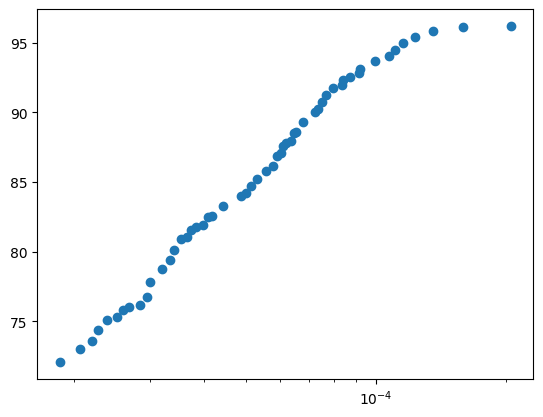

In [16]:
psrr = final_dict["psrr_2stage"]
area = final_dict["area"]

plt.scatter(area, 20*np.log10(psrr))
plt.xscale("log")

In [17]:
W_diff = np.tile(diffpair_primitive.W.flatten(), 5).reshape(5, 100)
L_diff = np.tile(diffpair_primitive.L.flatten(), 5).reshape(5, 100)

W_al = np.repeat(ota_cm_pmos.W.flatten(), 100).reshape(5, 100)
L_al = np.repeat(ota_cm_pmos.L.flatten(), 100).reshape(5, 100)

In [18]:
index = 0

#print(20*np.log10(ldo_results[0][index]))
#print(W_diff.flatten()[mask][index])
#print(L_diff.flatten()[mask][index])
#print(W_al.flatten()[mask][index])
#print(L_al.flatten()[mask][index])

In [19]:
print(final_dict.iloc[index])
psrr = 20*np.log10(final_dict["psrr_1stage"].values)[index]
print(psrr)

Ra_1stage      2.050079e+05
gma_1stage     2.085160e-04
Ca_1stage      1.000000e-17
gm_stage2      1.109046e-04
Ro_stage2      8.471525e+05
psrr_2stage    4.016255e+03
rout_2stage    8.471525e+05
gm_2stage      4.740888e-03
W_diff         3.803977e-06
L_diff         8.000000e-07
W_aload        3.483107e-06
L_aload        8.000000e-07
W_2stage       8.071432e-06
L_2stage       1.600000e-06
area           1.855852e-05
Name: 0, dtype: float64


KeyError: 'psrr_1stage'

In [61]:
final_dict[Symbol("W_diff")].values

array([3.80397680e-06, 5.84736756e-06, 5.94140697e-06, 1.20985026e-06,
       1.72125973e-06, 1.18560465e-06, 1.49525906e-06, 1.94917549e-06,
       2.65046727e-06, 3.80397680e-06, 5.84736756e-06, 2.06378434e-06,
       2.56151256e-06, 3.26667229e-06, 4.31082822e-06, 5.94140697e-06,
       8.65833631e-06, 3.83549017e-06, 4.72375359e-06, 5.95748419e-06,
       7.73926030e-06, 1.04362366e-05, 1.47616142e-05, 7.50704243e-06,
       9.17573862e-06, 1.14663882e-05, 2.06378434e-06, 2.56151256e-06,
       3.26667229e-06, 4.31082822e-06, 3.83549017e-06, 4.72375359e-06,
       5.95748419e-06, 7.73926030e-06, 1.04362366e-05, 1.47616142e-05,
       2.22003070e-05, 7.50704243e-06, 9.17573862e-06, 1.14663882e-05,
       1.47276581e-05, 1.95790317e-05, 2.71981489e-05, 3.83549017e-06,
       4.72375359e-06, 5.95748419e-06, 7.73926030e-06, 1.04362366e-05,
       7.50704243e-06, 9.17573862e-06, 1.14663882e-05, 1.47276581e-05,
       1.95790317e-05, 2.71981489e-05, 3.99815192e-05, 6.31784038e-05,
      

In [68]:
W_diff_pf = (final_dict[Symbol("W_diff")].values*1e6)
L_diff_pf = (final_dict[Symbol("L_diff")].values*1e6)

W_al_pf = (final_dict[Symbol("W_aload")].values*1e6)
L_al_pf = (final_dict[Symbol("L_aload")].values*1e6)

W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

In [69]:
mult_diff = []
for idx, i in enumerate(W_diff_pf):
    if i>100:
        mult_diff.append(10)
        W_diff_pf[idx] = W_diff_pf[idx]/10
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
        W_al_pf[idx] = W_al_pf[idx]/10
    else:
        mult_al.append(1)

mult_s2 = []
for idx, i in enumerate(W_s2_pf):
    if i>100:
        mult_s2.append(10)
        W_s2_pf[idx] = W_s2_pf[idx]/10
    else:
        mult_s2.append(1)

In [75]:
values = {
    "XM1": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_pf,
        L_diff_pf,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM4": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM5": [
        W_s2_pf,
        L_s2_pf,
        mult_s2,
        "pfet",
    ],
}

simulation_results = spice_sim("stage2_OTA_tb_sim", values)

[array([ 3.8039768 ,  5.84736756,  1.94917549,  2.65046727,  3.8039768 ,
        5.84736756,  4.31082822,  5.94140697,  8.65833631,  5.95748419,
        3.8039768 ,  5.84736756,  1.94917549,  2.65046727,  3.8039768 ,
        5.84736756,  4.31082822,  5.94140697,  8.65833631,  5.95748419,
        7.7392603 , 10.43623662, 14.76161425,  4.72375359,  5.95748419,
        7.7392603 , 10.43623662,  2.65046727,  3.8039768 ,  5.84736756,
        4.31082822,  5.94140697,  8.65833631,  5.95748419,  7.7392603 ,
       10.43623662, 14.76161425,  4.72375359,  5.95748419,  7.7392603 ,
       10.43623662, 14.76161425, 22.20030701, 11.46638824, 14.72765815,
       19.57903173, 27.19814885, 11.46638824, 14.72765815, 19.57903173,
       27.19814885, 39.98151921, 63.17840375, 10.92025518]), array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.6, 1.6, 1.6, 3.2, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.8, 1.6, 1.6, 1.6, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2,
       3.2, 0.8, 0.8, 0.8, 1.6, 1.6, 1.6, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2,
  

In [76]:
for idx, _ in enumerate(W_diff_pf):
    print(simulation_results[idx].iloc[0,1] - 20*np.log10(final_dict["psrr_2stage"].values[idx]))

2.400447936976917
2.5253980292414298
-0.5780436654142989
-0.3247742716343822
-0.41238281504283236
-0.2745861155437126
0.1175360182035945
0.0472729085730208
-0.016228654598009484
0.10674989733234952
3.4602084241044793
3.5851583163689753
-3.2521143782867483
-2.9988470845068207
-3.0864547279152816
-2.948658028416162
-2.5565330946688505
-2.6267925042994165
-2.6903031674704607
-2.567312815540106
-2.404671127241599
-2.498293627915487
-2.603797147962368
-0.11108849435113655
0.1815363460814865
0.39684159734069624
0.2539410128674007
-9.084471536043168
-9.17207987945163
-9.034292779952509
-8.642166346205187
-8.71243265583577
-8.77593881900681
-8.652925367076449
-8.490300178777971
-8.583923679451857
-8.689425599498719
-2.2709627458874877
-1.9783705054548477
-1.7630433541956734
-1.90592103866895
-2.055435771329442
-2.20436199679294
-2.0920903301764184
-2.1300010567480143
-2.1687799292064653
-2.2081453150154573
0.09685526093659291
0.045141074836649864
-0.0051594604985041315
-0.05427831845040032
-0.